In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [2]:
SIZE = 4  # map size

env = gym.make('FrozenLake-v1', is_slippery=False)
print(env.desc)

def int2loc(x):
    """
    Convert state number into 2d matrix index
    e.g. 3 -> (0, 4),  4 -> (1, 0)
    """
    return (x // SIZE, x % SIZE)

assert int2loc(8) == (2,0)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


# n-step Q-learning

In [ ]:
# *not to be confused with Q(sigma) described in the book
# this is actually an alternative to n-step SARSA

In [6]:
def episode(env, agent, test=False):
    
    agent.test_mode = test
    state = int2loc(env.reset())
    
    for step in range(MAX_STEPS):
        
        # choose next action
        action = agent.action(state)
        
        # take action & observe
        state_, reward, done, _ = env.step(action)
        state_ = int2loc(state_)
        agent.observe(reward, state_, done);

        if done:
            return reward
        
        # iter to next step
        state = state_

In [37]:
def cum_returns(rewards, gamma):
    """Discounted cumulative return on a given reward sequence"""
    return sum([(gamma ** i) * rewards[i] for i in range(len(rewards))])
    
class NQL():
    
    def __init__(self, n=3, choice=[0,1,2,3], shape=(SIZE, SIZE, 4), e=0.8, y=0.9, lr=1e-1,):
        
        self.n  = n
        self.state_actions = deque(maxlen=n)
        self.rewards = deque(maxlen=n)
        
        self.e  = e  # epsilon
        self.y  = y  # gamma
        self.lr = lr  # learning rate
        self.q = np.random.randn(*shape)  # q value array
        self.choice = choice  # action space
        
        self.test_mode = False
    
    def action(self, state):
        if not self.test_mode and np.random.rand() <= self.e:
            action = np.random.choice(self.choice)
        else:
            action = np.argmax(self.q[state])
        self.state_actions.append((*state, action))
        return action
    
    def observe(self, reward, state_, done):
        self.rewards.append(reward)
        
        # start learning once enough steps are simulated
        if len(self.rewards) == self.n:
            self.learn(state_, done)
    
    def reset(self):
        self.state_actions = deque(maxlen=self.n)
        self.rewards = deque(maxlen=self.n)
    
    def learn(self, state_, done):
        
        if not done:
            # update according to t:t+n rewards
            idx = self.state_actions[0]  # index for (state, action)
            g = cum_returns(self.rewards, self.y) + (self.y ** self.n) * np.max(self.q[state_])
            self.q[idx] += self.lr * (g - self.q[idx])
        
        else:
            # update with n-1, n-2, ... steps
            for i in range(self.n):
                idx = self.state_actions[i]
                g = cum_returns(list(self.rewards)[i:], self.y) + 0.0
                self.q[idx] += self.lr * (g - self.q[idx])

In [38]:
EPISODES = 1000
MAX_STEPS = 100  # max steps before terminating an episode

agents = [NQL(n=5, e=0.4, lr=0.2) for _ in range(5)]
rewards = []

for i in range(EPISODES):
    
    [episode(env, agt) for agt in agents];
        
    if i % 20 == 0:
        r = [episode(env, agt, test=True) for agt in agents]
        rewards.append(sum(r) / len(r))
        
    [agt.reset() for agt in agents];

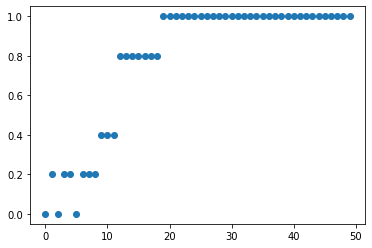

In [39]:
plt.scatter(range(len(rewards)), rewards);

In [40]:
arrows = np.array(['←','↓','→','↑'])
np.array([arrows[np.argmax(agents[0].q, axis=2)[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(4) for j in range(4)
          ]).reshape(4,4)

array([['→', '→', '↓', '←'],
       ['↑', 'H', '↓', 'H'],
       ['↓', '→', '↓', 'H'],
       ['H', '→', '→', 'G']], dtype='<U1')

In [ ]:
# TODO
# implement off-policy n-step methods